# Classification CIFAR-10

In [1]:
import tensorflow as tf
import numpy as np

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Load Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Print dimensions of training data
print("Training data shape: ", x_train.shape)
print("Training labels shape: ", y_train.shape)

# Print dimensions of test data
print("Test data shape: ", x_test.shape)
print("Test labels shape: ", y_test.shape)

# Print number of unique classes
num_classes = len(np.unique(y_train))
print("Number of classes: ", num_classes)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)
Number of classes:  10


#### Data Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images by 10 degrees
    width_shift_range=0.1,  # randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,  # randomly shift images vertically by 10% of the height
    zoom_range=0.1,  # randomly zoom images by 10%
    horizontal_flip=True  # randomly flip images horizontally
)

data_gen_batch_size = 64

In [4]:
# # Fit the ImageDataGenerator on x_train
# datagen.fit(x_train)

# # Generate augmented images
# augmented_images = datagen.flow(x_train, y_train, batch_size=data_gen_batch_size)

# # Iterate over the augmented images and append them to x_train
# for i, (x_batch, y_batch) in enumerate(augmented_images):
#     x_train = np.concatenate((x_train, x_batch), axis=0)
#     y_train = np.concatenate((y_train, y_batch), axis=0)
#     if i >= len(x_train) // data_gen_batch_size:
#         break

# # Print the new dimensions of x_train
# print("New dimensions of x_train: ", x_train.shape)
# print("New dimensions of y_train: ", y_train.shape)


### Preprocess data

In [5]:
from tensorflow.keras.utils import to_categorical

In [6]:
# Settings
resize = (224, 224) # (32, 32) # (224, 224)
auto_encode = True

In [7]:
# One hot encode labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Load as tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Normalize images
def normalize_img(image, label):

    # Resize images
    image = tf.image.resize(image, resize)
    image = tf.cast(image, tf.float32) / 255.

    return image, label if not auto_encode else image

# Normalise images
ds_train = train_dataset.map(normalize_img)
ds_test = test_dataset.map(normalize_img)

## Declare model

In [8]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, \
    AveragePooling2D, BatchNormalization, Activation, Add, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomFlip, RandomTranslation

In [9]:
# Define initializer
initializer = tf.initializers.he_normal(seed=42) # tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=42)
classification_initializer = tf.initializers.glorot_normal(seed=42)

activation_function = 'relu' # 'selu'
use_bias = False # Batch Norm takes care of it
epsilon_bn = 1.001e-5
kernel_reg = tf.keras.regularizers.l2(0.0001)

### ResNet Blocks

#### Identity Block

In [10]:
# Define resnet identity block

def identity_block(filter, kernel_size=3):
    def _identity_block(x):
        input_x = x

        # Layer 1
        x = Conv2D(filter, kernel_size=kernel_size, 
                   padding = 'same', kernel_initializer=initializer,
                   use_bias=use_bias, kernel_regularizer=kernel_reg)(x)
        x = BatchNormalization(axis=3, epsilon=epsilon_bn)(x)
        x = Activation(activation_function)(x)

        # Layer 2
        x = Conv2D(filter, kernel_size=kernel_size, 
                   padding = 'same', kernel_initializer=initializer,
                   use_bias=use_bias, kernel_regularizer=kernel_reg)(x)
        x = BatchNormalization(axis=3, epsilon=epsilon_bn)(x)

        # Add Residue
        x = Add()([x, input_x])
        
        # Activation
        x = Activation(activation_function)(x)

        return x
    
    return _identity_block

#### Convolutional Res Block

In [11]:
# Define resnet convolutional block

def convolutional_res_block(filter, kernel_size=3):
    def _convolutional_res_block(x):
        input_x = x

        # Layer 1
        x = Conv2D(filter, kernel_size=kernel_size, 
                   padding = 'same', kernel_initializer=initializer,
                   use_bias=use_bias, kernel_regularizer=kernel_reg)(x)
        x = BatchNormalization(axis=3, epsilon=epsilon_bn)(x)
        x = Activation(activation_function)(x)

        # Layer 2
        x = Conv2D(filter, kernel_size=kernel_size, 
                   padding = 'same', kernel_initializer=initializer,
                   use_bias=use_bias, kernel_regularizer=kernel_reg)(x)
        x = BatchNormalization(axis=3, epsilon=epsilon_bn)(x)

        # Layer 3
        input_x = Conv2D(filter, kernel_size=kernel_size, 
                   padding = 'same', kernel_initializer=initializer,
                   use_bias=use_bias, kernel_regularizer=kernel_reg)(input_x)
        input_x = BatchNormalization(axis=3, epsilon=epsilon_bn)(input_x)

        # Add Residue
        x = Add()([x, input_x])
        
        # Activation
        x = Activation(activation_function)(x)

        return x
    
    return _convolutional_res_block

#### Reduction Convolutional Res Block

In [12]:
# Define reduction convolutional block

def reduction_convolutional_res_block(filter, kernel_size=3, strides=2):
    def _reduction_convolutional_res_block(x):
        input_x = x

        # Layer 1
        x = Conv2D(filter, kernel_size=kernel_size, 
                   padding = 'same', kernel_initializer=initializer,
                   use_bias=use_bias, kernel_regularizer=kernel_reg)(x)
        x = BatchNormalization(axis=3, epsilon=epsilon_bn)(x)
        x = Activation(activation_function)(x)

        # Layer 2
        x = Conv2D(filter, kernel_size=kernel_size, 
                   padding = 'same', kernel_initializer=initializer,
                   use_bias=use_bias, strides=strides, kernel_regularizer=kernel_reg)(x)
        x = BatchNormalization(axis=3, epsilon=epsilon_bn)(x)

        # Layer 3
        input_x = Conv2D(filter, kernel_size=kernel_size, 
                   padding = 'same', kernel_initializer=initializer,
                   use_bias=use_bias, strides=strides, kernel_regularizer=kernel_reg)(input_x)
        input_x = BatchNormalization(axis=3, epsilon=epsilon_bn)(input_x)

        # Add Residue
        x = Add()([x, input_x])

        x = Activation(activation_function)(x)

        return x
    
    return _reduction_convolutional_res_block

### Other Blocks

#### Convolutional Block

In [13]:
# Convolutional block
def convolutional_block(filter, kernel_size=3, strides=2):
    def _convolutional_block(x):
        
        x = Conv2D(filter, kernel_size=kernel_size, 
                   padding = 'same', kernel_initializer=initializer,
                   use_bias=use_bias, strides=strides, kernel_regularizer=kernel_reg)(x)
        x = BatchNormalization(axis=3, epsilon=epsilon_bn)(x)
        x = Activation(activation_function)(x)

        return x
    
    return _convolutional_block

### Model definition

In [14]:
model_name = 'model'

#### Data augmentation

In [15]:
if not auto_encode:
    
    data_aug = [
        RandomRotation(0.1, seed=42),
        RandomTranslation(0.1, 0.1, seed=42),
        RandomZoom(0.1, seed=42),
        RandomFlip(seed=42),
    ]

#### ResNet 18

In [16]:
model_name = 'resnet_18' # 'resnet_5'

conv_net = [
    convolutional_block(64, kernel_size = 7, strides = 2),
    AveragePooling2D(pool_size=3, strides = 2, padding = 'same'),

    identity_block(64),
    identity_block(64),

    convolutional_block(128),
    identity_block(128),

    convolutional_block(256),
    identity_block(256),

    convolutional_block(512),
    identity_block(512),

    AveragePooling2D(pool_size=7)
]

In [17]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.layers import Conv2DTranspose

if auto_encode:

    model_name = model_name + '_auto_encode'

    def deconvolution(kernels, kernel_size = 3, strides = 2, act_fun = activation_function):
        def _deconvolution(x):
            x = Conv2DTranspose(kernels, kernel_size=kernel_size, 
                                strides=strides, padding='same', kernel_initializer=initializer,
                                use_bias=use_bias, kernel_regularizer=kernel_reg)(x)
            x = BatchNormalization(axis=3, epsilon=epsilon_bn)(x)
            x = Activation(act_fun)(x)

            return x

        return _deconvolution

    # decoder_net = [
    #     Resizing(7, 7),#, interpolation='nearest'),

    #     deconvolution(512),
    #     deconvolution(256),
    #     deconvolution(128),
    #     deconvolution(64),

    #     Resizing(112, 112),#, interpolation='nearest'),

    #     deconvolution(3, kernel_size=7, strides=2, act_fun='sigmoid'),
    # ]

    model_name = model_name + '_auto_encode_convs'

    def conv_resize(kernels, size, kernel_size = 3, strides = 2, act_fun = activation_function):
        def _conv_resize(x):
            x = Resizing(size, size)(x)
            x = Conv2D(kernels, kernel_size=kernel_size, 
                                strides=strides, padding='same', kernel_initializer=initializer,
                                kernel_regularizer=kernel_reg)(x) # use_bias=use_bias,
            # x = BatchNormalization(axis=3, epsilon=epsilon_bn)(x)
            x = Activation(act_fun)(x)

            return x

        return _conv_resize

    decoder_net = [
        
        Resizing(7, 7),#, interpolation='nearest'),

        conv_resize(512, 14, strides=2),
        conv_resize(256, 28, strides=2),    
        conv_resize(128, 56, strides=2),
        conv_resize(64, 112, strides=2),
        
        conv_resize(3, 224, kernel_size=7, strides=1, act_fun='sigmoid')
    ]

#### ResNet 9

In [18]:
# model_name = 'resnet9'

# conv_net = [
#     convolutional_block(64, kernel_size = 3, strides = 1),

#     convolutional_block(128, kernel_size = 3, strides = 1),
#     MaxPooling2D(pool_size=2, strides = 2, padding = 'same'),
    
#     identity_block(128),

#     convolutional_block(256, kernel_size = 3, strides = 1),
#     MaxPooling2D(pool_size=2, strides = 2, padding = 'same'),

#     convolutional_block(512, kernel_size = 3, strides = 1),
#     MaxPooling2D(pool_size=2, strides = 2, padding = 'same'),

#     identity_block(512),
#     MaxPooling2D(pool_size=4, strides = 4, padding = 'same')
# ]

#### LittleNet

In [19]:
# model_name = 'littlenet'

# conv_net = [
#     convolutional_block(32, kernel_size = 3, strides = 2),
#     MaxPooling2D(pool_size=2, strides = 2, padding = 'same'),

#     convolutional_block(64, kernel_size = 3, strides = 2),

#     convolutional_block(128, kernel_size = 3, strides = 2),
#     MaxPooling2D(pool_size=4, strides = 4, padding = 'same')
# ]

#### Load Model

In [20]:
load_model_name = None
if False:
    model_name = 'resnet_4_1'
    load_model_name = 'resnet_4'

#### Classification

In [21]:
if not auto_encode:

    classification_net = [
        Flatten(),
        Dense(128, kernel_initializer=initializer, activation=activation_function),
        Dropout(0.5),
        Dense(num_classes, kernel_initializer=classification_initializer, activation='softmax')
    ]

In [22]:
# classification_net = [
#     Flatten(),
#     Dense(num_classes, kernel_initializer=classification_initializer, activation='softmax')
# ]

### Compile model

#### Compile functions

In [23]:
# Define input layer
input_shape = (resize[0], resize[1], 3)
input_layer = Input(shape=input_shape)

In [24]:
def create_classifier():

    def compile_layers(input, layers):
        for layer in layers:
            input = layer(input)
        return input
    
    output_layer = None
    
    if not auto_encode:

        # Build Data augmentation
        data_augmentation_layers = compile_layers(input_layer, data_aug)

        # Build Feature Extractor
        conv_net_layers = compile_layers(data_augmentation_layers, conv_net)

        # Build Classifier
        classification_layers = compile_layers(conv_net_layers, classification_net)

        output_layer = classification_layers

    else:
            
            # Build Feature Extractor
            conv_net_layers = compile_layers(input_layer, conv_net)
    
            # Build Decoder
            decoder_layers = compile_layers(conv_net_layers, decoder_net)

            output_layer = decoder_layers

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [25]:
# Create model
model = create_classifier()

In [26]:
if load_model_name is not None:
    model.load_weights('models/' + load_model_name + '.h5')  

#### Summary

In [27]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Train/Test model

In [28]:
# import tensorflow_addons as tfa

# Train settings
epochs = 100 # 200
batch_size = 8 # 64

# Define optimizer
learning_rate = 0.005
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate) #, clipvalue=0.1)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)

### Prepare data

In [29]:
# Configure Dataset for Performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# ds_train = ds_train.cache()
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)

ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)

del x_train, y_train, x_test, y_test

### Run train/test

In [30]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

import datetime

In [31]:
def train_test_model(model):

    if not auto_encode:
        loss = CategoricalCrossentropy(label_smoothing=0.2)
    else:
        loss = 'mse'

    # Compile model
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Save model callback
    checkpoint = ModelCheckpoint('models/' + model_name + '.h5', monitor='val_accuracy', 
                                save_best_only=True, mode='max', verbose=1)

    # Tensorboard callback
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_' + model_name
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    print('tensorboard --logdir ' + log_dir)

    # Train model
    run_hist = model.fit(ds_train, validation_data=ds_test,
                         epochs=epochs, batch_size=batch_size,
                         callbacks=[checkpoint, tensorboard_callback])
    
    return run_hist

In [32]:
# Run train and validation
run_hist = train_test_model(model)

tensorboard --logdir logs/fit/20231127-133754_resnet_18_auto_encode_auto_encode_convs
Epoch 1/100


   1/6250 [..............................] - ETA: 15s - loss: 0.8867 - accuracy: 0.4712WARNING:tensorflow:From c:\Users\benoi\AppData\Local\pypoetry\Cache\virtualenvs\tp-8inf919-aDMhdl4N-py3.8\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
6250/6250 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.4948
Epoch 00001: val_accuracy improved from -inf to 0.49705, saving model to models\resnet_18_auto_encode_auto_encode_convs.h5
6250/6250 [==============================] - 752s 120ms/step - loss: 0.1280 - accuracy: 0.4948 - val_loss: 0.0611 - val_accuracy: 0.4970
Epoch 2/100
6250/6250 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.4979
Epoch 00002: val_accuracy did not improve from 0.49705
6250/6250 [==============================] - 746s 119ms/step - loss: 0.06

KeyboardInterrupt: 

In [ ]:
# Run test
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(f'Test accuracy: {test_acc}')

157/157 - 25s - loss: 0.0339 - accuracy: 0.6878
Test accuracy: 0.6878199577331543


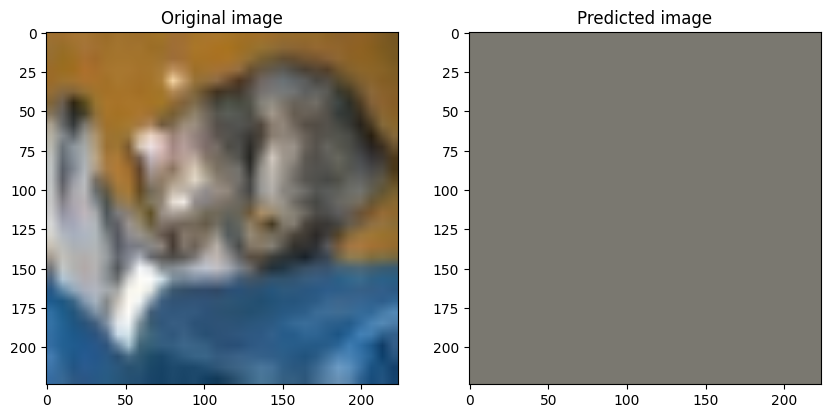

In [33]:
if auto_encode:
    # Show input output for one image
    for image, label in ds_test.take(1):
        pred = model.predict(image)

        # Show image
        import matplotlib.pyplot as plt
        # Make subplots
        fig, axs = plt.subplots(1, 2, figsize=(10, 10))

        # Show original image
        axs[0].imshow(image[0])
        axs[0].set_title('Original image')

        # Show predicted image
        axs[1].imshow(pred[0])
        axs[1].set_title('Predicted image')

        plt.show()

## Plot history

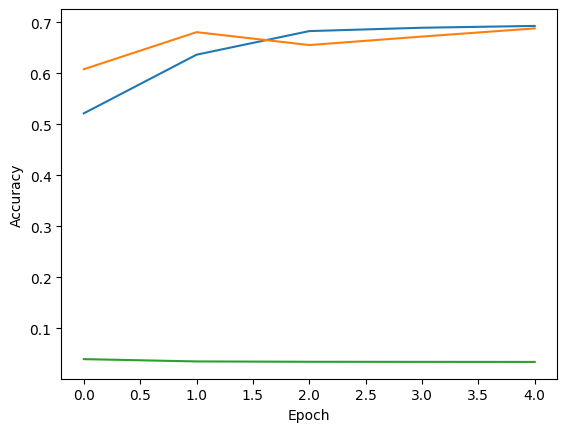

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.plot(run_hist.history['accuracy'], label='train')
plt.plot(run_hist.history['val_accuracy'], label='test')
plt.plot(run_hist.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()